In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline

In [2]:
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
# group data by activity
def data_by_activity(X, y, activities):
    # group windows by activity
    grouped=list()
    #return {a:X[y[:,0]==a] for a in activities}
    for i in activities:
        ac = X[Y[:,0]==i]
        grouped.append(ac)
        #print(i,ac.shape)

def load_all_data(directory):
    # Load
    filename="mHealth_subject1.csv"
    df = pd.read_csv(directory+filename)
    df.insert(0, 'id', 1)


    for i in range(9):
        number=str(i+2)
        filename="mHealth_subject"+number+".csv"
    #   print(directory+filename)
        df_subject = pd.read_csv(directory+filename)
        df_subject.insert(0, 'id', i+2)
        df = df.append(df_subject)



    # Cleaning
    df =df.query('label != 0')
    raw = df
    
    # Separate data
    X = df.iloc[:, :24]
    Y = df.iloc[:,24]

    return raw,X,Y


def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i + 1, counts[i], percent))


# Method to convert data to series
def to_series(data, off, activity_list, subject_id):
    subject_data = data.query('id==' + str(subject_id))
    series = [[]]
    for activity in activity_list:
        ser = np.asmatrix(subject_data.query("label=="+str(activity)).iloc[:, off]).T
        series=np.append(series,ser)
    return series


def min_max_normalization(X):
    row,columns=X.shape
    for i in range(columns):
        v = X[:, i]  
        X[:, i] = (v - v.min()) / ((v.max() - v.min()) if (v.max() - v.min())!=0 else 1)
    return X

def range_normalization(X,a,b):
    row,columns=X.shape
    for i in range(columns):
        v = X[:, i]  
        X[:, i] = (b-a)*((v - v.min()) / ((v.max() - v.min()) if (v.max() - v.min())!=0 else 1))+a
    return X
    

In [4]:
directory="Data/MHEALTHDATASET/"

raw,X,y=load_all_data(directory)
raw.head()

,id,acc_chest_x,acc_chest_y,acc_chest_z,elect_sig_1,elect_sig_2,acc_left_ank_x,acc_left_ank_y,acc_left_ank_z,gyr_left_ank_x,...,acc_right_arm_x,acc_right_arm_y,acc_right_arm_z,gyr_right_arm_x,gyr_right_arm_y,gyr_right_arm_z,mag_right_arm_x,mag_right_arm_y,mag_right_arm_z,label
3530,1,-9.8289,0.537270,2.1010,-0.121400,0.163270,2.4495,-9.7277,-0.493140,-0.25788,...,-1.6442,-9.8757,3.43330,-0.90784,-0.57290,0.084052,-3.3505,-11.89000,5.4671,8
3531,1,-10.0630,0.141760,2.0233,-0.192570,0.100470,1.7507,-9.7923,-0.024192,-0.25788,...,-2.5060,-9.7488,2.11670,-0.90784,-0.57290,0.084052,1.9181,-5.67690,-3.1540,8
3532,1,-9.6363,-0.002198,1.6945,-0.226060,0.020931,2.4836,-9.4641,0.124550,-0.25788,...,-2.6872,-9.9677,1.23080,-0.90784,-0.57290,0.084052,4.4654,-2.29000,-6.7470,8
3533,1,-9.5303,0.250110,1.8225,-0.159080,0.129770,2.5743,-9.3353,0.131890,-0.25788,...,-2.6247,-9.7028,0.72319,-0.90784,-0.57290,0.084052,6.4595,-0.37111,-12.5020,8
3534,1,-9.2791,0.317060,1.4391,-0.037677,0.267920,2.8298,-9.2048,0.307640,-0.28200,...,-2.7955,-9.2540,0.59980,-0.91176,-0.58522,0.101290,7.2062,2.48540,-16.4870,8


In [5]:
# to beginning we are only going to use accelerometer
valid_activities_set=raw.copy()#raw.query("label==1 or label==4")
valid_activities_set.columns

# Get only 2 activities and accelerometer data
# data=valid_activities_set[['id','acc_chest_x'    , 'acc_chest_y'    , 'acc_chest_z','label']].copy()
data=valid_activities_set[['id','acc_chest_x'    , 'acc_chest_y'    , 'acc_chest_z',
                               'acc_left_ank_x' , 'acc_left_ank_y' , 'acc_left_ank_z',
                               'acc_right_arm_x', 'acc_right_arm_y', 'acc_right_arm_z','label']].copy()



data

,id,acc_chest_x,acc_chest_y,acc_chest_z,acc_left_ank_x,acc_left_ank_y,acc_left_ank_z,acc_right_arm_x,acc_right_arm_y,acc_right_arm_z,label
3530,1,-9.8289,0.537270,2.1010,2.4495,-9.7277,-0.493140,-1.64420,-9.8757,3.43330,8
3531,1,-10.0630,0.141760,2.0233,1.7507,-9.7923,-0.024192,-2.50600,-9.7488,2.11670,8
3532,1,-9.6363,-0.002198,1.6945,2.4836,-9.4641,0.124550,-2.68720,-9.9677,1.23080,8
3533,1,-9.5303,0.250110,1.8225,2.5743,-9.3353,0.131890,-2.62470,-9.7028,0.72319,8
3534,1,-9.2791,0.317060,1.4391,2.8298,-9.2048,0.307640,-2.79550,-9.2540,0.59980,8
...,...,...,...,...,...,...,...,...,...,...,...
98299,10,-5.3457,4.151600,-6.3632,2.3506,-5.9169,-5.553600,0.42673,-6.4275,6.25150,9
98300,10,-4.6643,3.923400,-6.0995,2.3964,-6.7119,-5.842900,2.63850,-5.0859,4.41240,9
98301,10,-5.3018,3.978800,-5.1998,1.8620,-6.1254,-4.621000,-0.83903,-10.1930,5.69870,9
98302,10,-5.7742,1.842100,-5.1395,2.2890,-6.1167,-3.751700,-4.48930,-6.7477,9.22510,9


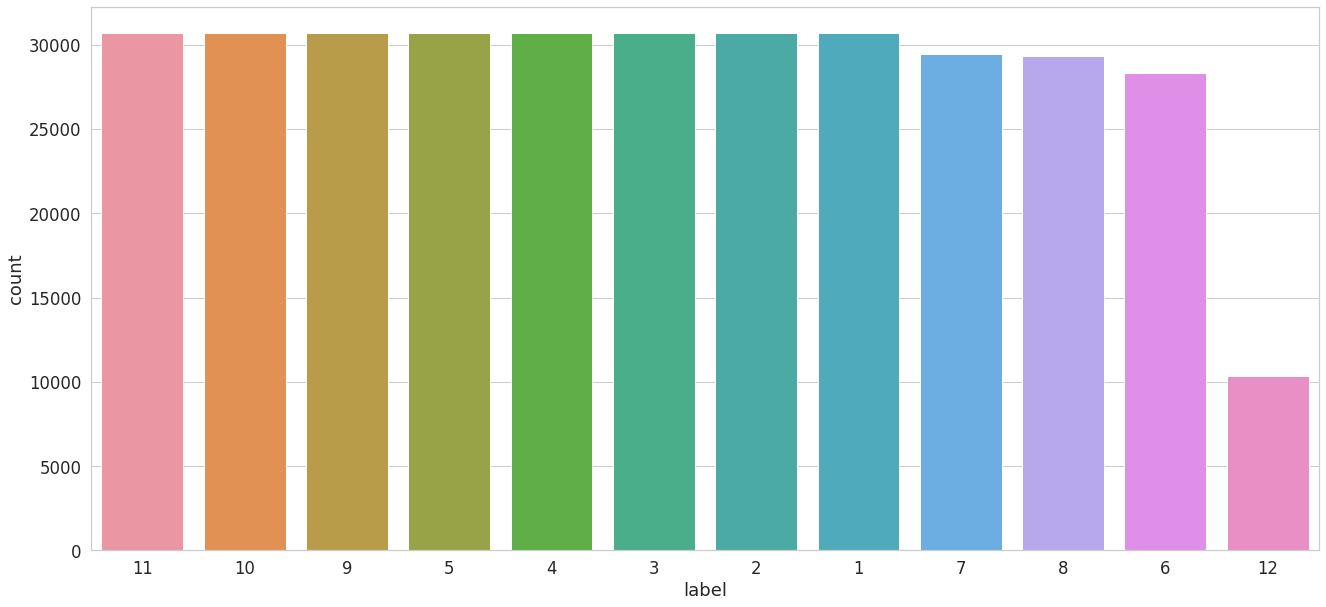

In [6]:
sns.countplot(x = 'label',
              data = data,
              order = data.label.value_counts().index);

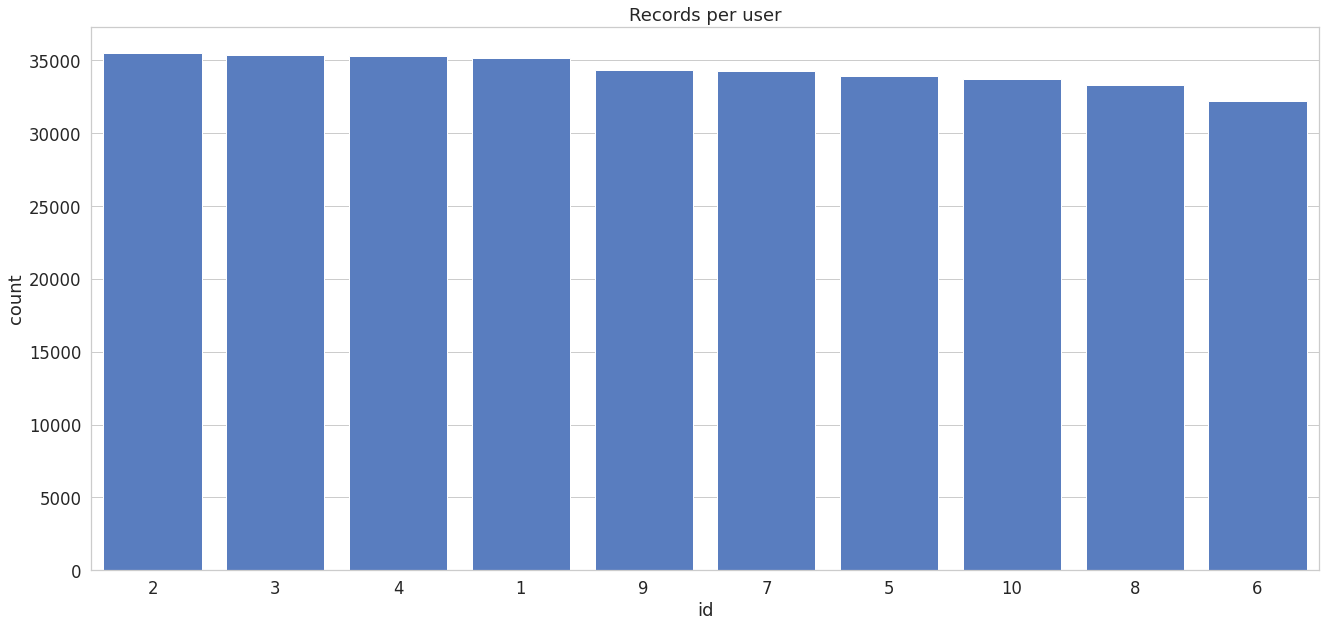

In [7]:
sns.countplot(x = 'id',
              data = data,
              palette=[sns.color_palette()[0]],
              order = data.id.value_counts().index);
plt.title("Records per user");

In [8]:
def plot_activity(activity, df):
    data = (df.query("label=="+activity))[['acc_chest_x'    , 'acc_chest_y'    , 'acc_chest_z',
                               'acc_left_ank_x' , 'acc_left_ank_y' , 'acc_left_ank_z',
                               'acc_right_arm_x', 'acc_right_arm_y', 'acc_right_arm_z']][:128]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

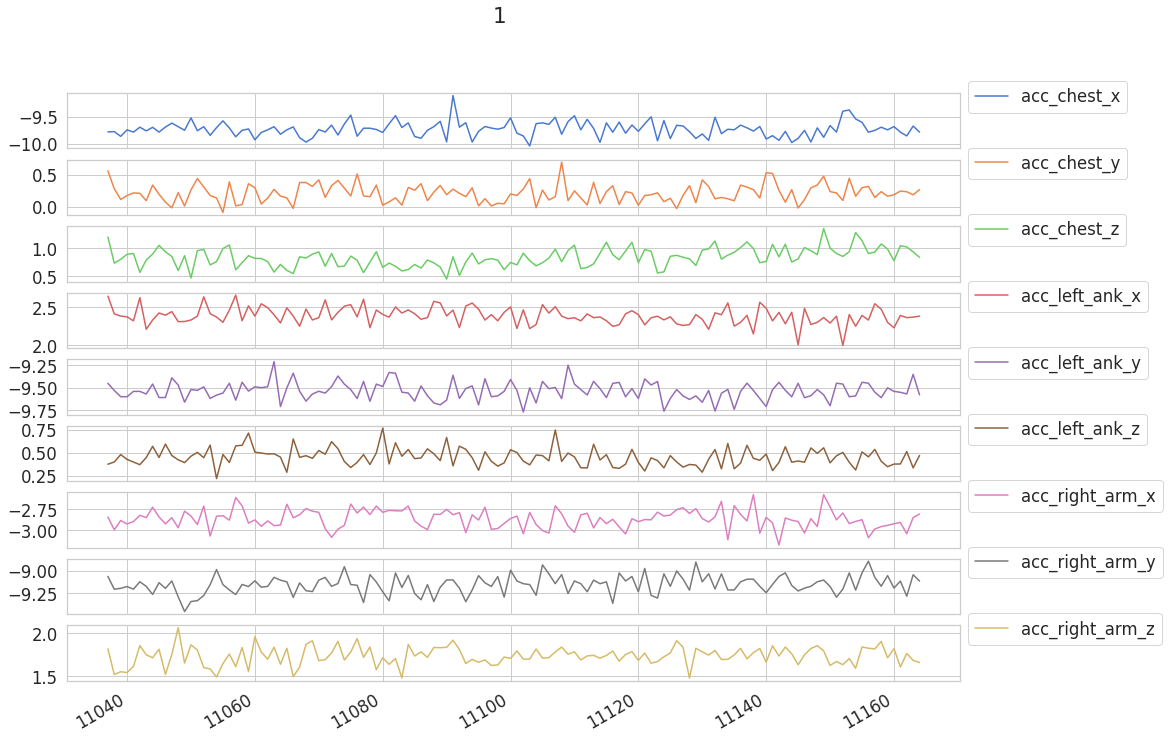

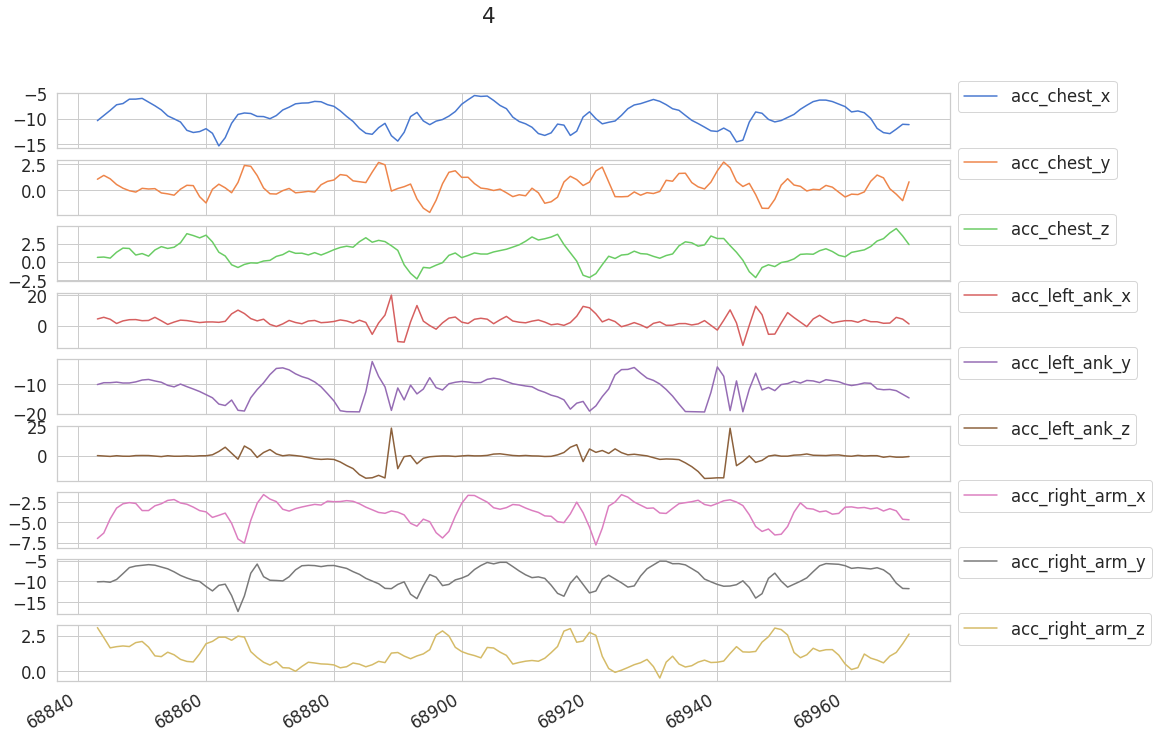

In [9]:
plot_activity("1", data);
plot_activity("4", data);

In [10]:
df_train = data[data['id'] <= 7]
df_test = data[data['id'] > 7]

In [11]:
from sklearn.preprocessing import RobustScaler

def range_normalization(X,a,b):
    row,columns=X.shape
    for i in range(columns):
        v = X[:, i]  
        X[:, i] = (b-a)*((v - v.min()) / ((v.max() - v.min()) if (v.max() - v.min())!=0 else 1))+a
    return X



scale_columns = ['acc_chest_x'    , 'acc_chest_y'    , 'acc_chest_z',
                               'acc_left_ank_x' , 'acc_left_ank_y' , 'acc_left_ank_z',
                               'acc_right_arm_x', 'acc_right_arm_y', 'acc_right_arm_z']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = range_normalization(df_train[scale_columns].to_numpy(),-1,1)#scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = range_normalization(df_test[scale_columns].to_numpy(),-1,1)#scaler.transform(df_test[scale_columns].to_numpy())

/home/liliana/.local/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
df_train

,id,acc_chest_x,acc_chest_y,acc_chest_z,acc_left_ank_x,acc_left_ank_y,acc_left_ank_z,acc_right_arm_x,acc_right_arm_y,acc_right_arm_z,label
3530,1,-0.392801,0.005260,-0.021851,0.166295,-0.514895,-0.149326,-0.017662,-0.555595,-0.014471,8
3531,1,-0.404074,-0.014045,-0.025558,0.133145,-0.518063,-0.128196,-0.058558,-0.549395,-0.074345,8
3532,1,-0.383526,-0.021071,-0.041245,0.167913,-0.501967,-0.121495,-0.067157,-0.560090,-0.114632,8
3533,1,-0.378421,-0.008756,-0.035138,0.172215,-0.495650,-0.121164,-0.064191,-0.547148,-0.137716,8
3534,1,-0.366325,-0.005488,-0.053430,0.184336,-0.489250,-0.113245,-0.072296,-0.525222,-0.143327,8
...,...,...,...,...,...,...,...,...,...,...,...
102103,7,-0.239391,0.020366,-0.286193,0.125204,-0.535949,-0.209349,0.105948,-0.462183,-0.141815,8
102104,7,-0.248151,0.020677,-0.277123,0.080340,-0.529426,-0.188826,0.107690,-0.460180,-0.137458,8
102105,7,-0.237590,0.027712,-0.279518,0.068779,-0.501893,-0.204100,0.108993,-0.438713,-0.140249,8
102106,7,-0.245430,0.005943,-0.279928,0.055660,-0.534772,-0.193061,0.087649,-0.426382,-0.129253,8


In [13]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 128
STEP = 40

X_train, y_train = create_dataset(
    df_train[['acc_chest_x'    , 'acc_chest_y'    , 'acc_chest_z',
                               'acc_left_ank_x' , 'acc_left_ank_y' , 'acc_left_ank_z',
                               'acc_right_arm_x', 'acc_right_arm_y', 'acc_right_arm_z']], 
    df_train.label, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['acc_chest_x'    , 'acc_chest_y'    , 'acc_chest_z',
                               'acc_left_ank_x' , 'acc_left_ank_y' , 'acc_left_ank_z',
                               'acc_right_arm_x', 'acc_right_arm_y', 'acc_right_arm_z']], 
    df_test.label, 
    TIME_STEPS, 
    STEP
)

In [14]:
print(X_train.shape, y_train.shape)

(6043, 128, 9) (6043, 1)


In [15]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [16]:
print(X_train.shape, y_train.shape)

(6043, 128, 9) (6043, 12)


In [39]:
model = keras.Sequential()
model.add(
    #keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    #)
)
#model.add(keras.layers.Dropout(rate=0.5))
#model.add(keras.layers.Dense(units=100, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [40]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/300
85/85 [==============================] - 8s 98ms/step - loss: 1.7230 - acc: 0.3808 - val_loss: 1.1734 - val_acc: 0.3752
Epoch 2/300
85/85 [==============================] - 8s 90ms/step - loss: 1.3082 - acc: 0.4899 - val_loss: 2.1903 - val_acc: 0.4579
Epoch 3/300
85/85 [==============================] - 8s 90ms/step - loss: 1.5402 - acc: 0.4178 - val_loss: 1.1852 - val_acc: 0.4975
Epoch 4/300
85/85 [==============================] - 8s 90ms/step - loss: 1.1787 - acc: 0.5816 - val_loss: 0.9778 - val_acc: 0.5950
Epoch 5/300
85/85 [==============================] - 8s 94ms/step - loss: 0.9259 - acc: 0.6762 - val_loss: 1.0384 - val_acc: 0.5851
Epoch 6/300
85/85 [==============================] - 8s 96ms/step - loss: 1.0743 - acc: 0.5938 - val_loss: 1.3681 - val_acc: 0.3967
Epoch 7/300
85/85 [==============================] - 8s 94ms/step - loss: 1.2664 - acc: 0.5752 - val_loss: 1.8318 - val_acc: 0.4860
Epoch 8/300
85/85 [==============================] - 8s 94ms/step - loss: 1.

85/85 [==============================] - 8s 89ms/step - loss: 1.6617 - acc: 0.4636 - val_loss: 1.2761 - val_acc: 0.5950
Epoch 124/300
85/85 [==============================] - 8s 90ms/step - loss: 1.2512 - acc: 0.5980 - val_loss: 0.9450 - val_acc: 0.7488
Epoch 125/300
85/85 [==============================] - 8s 90ms/step - loss: 1.2219 - acc: 0.6249 - val_loss: 1.5564 - val_acc: 0.3008
Epoch 126/300
85/85 [==============================] - 8s 89ms/step - loss: 1.6649 - acc: 0.4950 - val_loss: 1.0083 - val_acc: 0.6512
Epoch 127/300
85/85 [==============================] - 8s 89ms/step - loss: 1.1172 - acc: 0.6249 - val_loss: 1.2476 - val_acc: 0.4926
Epoch 128/300
85/85 [==============================] - 8s 90ms/step - loss: 0.8953 - acc: 0.6778 - val_loss: 0.7915 - val_acc: 0.7025
Epoch 129/300
85/85 [==============================] - 8s 89ms/step - loss: 1.0811 - acc: 0.6291 - val_loss: 0.8693 - val_acc: 0.6711
Epoch 130/300
85/85 [==============================] - 8s 90ms/step - loss: 

85/85 [==============================] - 8s 95ms/step - loss: 0.0897 - acc: 0.9755 - val_loss: 0.2815 - val_acc: 0.9223
Epoch 185/300
85/85 [==============================] - 8s 93ms/step - loss: 0.0713 - acc: 0.9814 - val_loss: 0.1453 - val_acc: 0.9702
Epoch 186/300
85/85 [==============================] - 8s 95ms/step - loss: 0.0781 - acc: 0.9781 - val_loss: 0.2538 - val_acc: 0.9421
Epoch 187/300
85/85 [==============================] - 8s 88ms/step - loss: 0.2772 - acc: 0.9248 - val_loss: 0.1832 - val_acc: 0.9686
Epoch 188/300
85/85 [==============================] - 8s 92ms/step - loss: 0.0902 - acc: 0.9794 - val_loss: 0.1792 - val_acc: 0.9669
Epoch 189/300
85/85 [==============================] - 8s 98ms/step - loss: 0.0749 - acc: 0.9801 - val_loss: 0.2125 - val_acc: 0.9421
Epoch 190/300
85/85 [==============================] - 8s 98ms/step - loss: 0.1747 - acc: 0.9566 - val_loss: 0.2229 - val_acc: 0.9405
Epoch 191/300
85/85 [==============================] - 9s 103ms/step - loss:

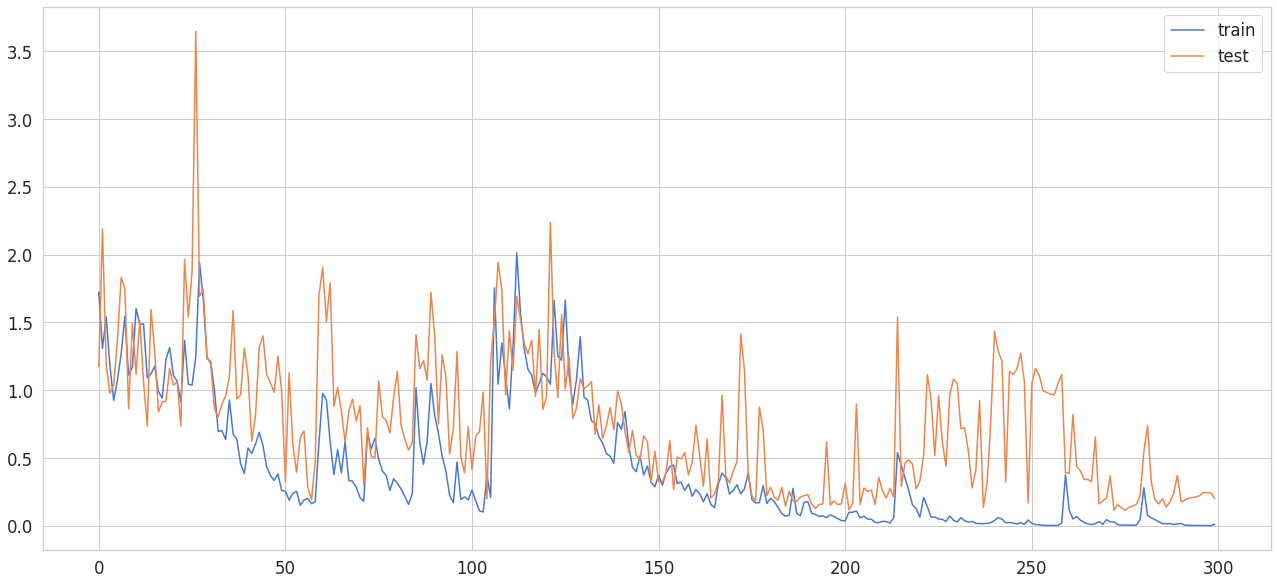

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [42]:
model.evaluate(X_test, y_test)

80/80 [==============================] - 2s 22ms/step - loss: 0.6067 - acc: 0.8989


[0.6066646575927734, 0.8988941311836243]

In [43]:
y_pred = model.predict(X_test)

In [44]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(18, 16)) 
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap=sns.diverging_palette(220, 20, n=7),
        ax=ax
    )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    


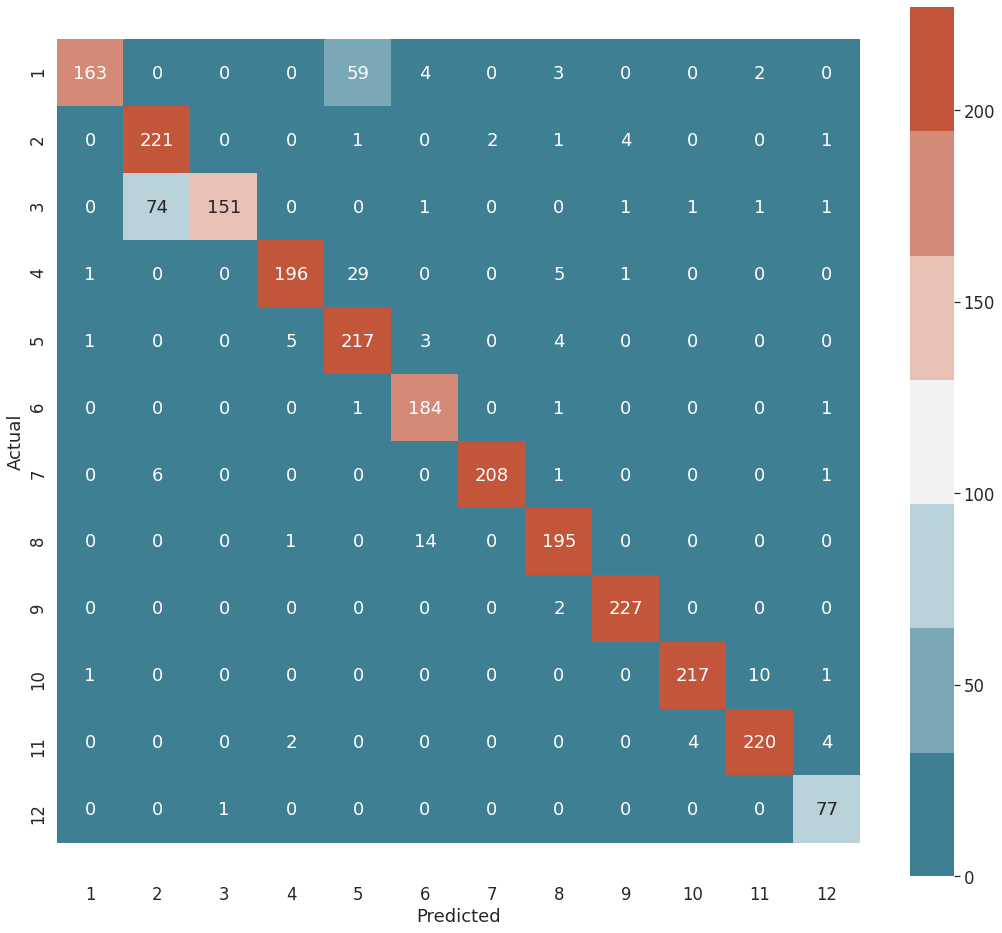

In [45]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

In [46]:
model.layers[0].output
model.layers[1].output

<tf.Tensor 'dense_1/Identity:0' shape=(None, 12) dtype=float32>

In [52]:
from keras import backend as K

outputs = []

for layer in model.layers:

    keras_function = K.function([model.input], [layer.output])

    outputs.append(keras_function([X_train, 1]))


print(outputs)

AttributeError: 'list' object has no attribute 'shape'